In [5]:
import numpy as np
import pandas as pd
import geopandas as gpd
import dask.dataframe as dd
from pathlib import Path

DATA_DIR = Path('../backend/api/data')
RAW_DATA = DATA_DIR / 'raw'
PROCESSED_DATA = DATA_DIR / 'processed'
INFOBUSES = RAW_DATA / 'infobuses'

df = dd.read_csv(INFOBUSES / '2018-05-01.gps.csv', sep=';') #meta = (str, str, str, float, float))
df['id'] = df['patente'] + '---' + df['recorrido']
df = df.drop(columns=['nose', 'nose1', 'nose2', 'nose3','nose4']).replace(' ', np.nan).dropna()
# df.compute()
df

,patente,recorrido,datetime,lat,lon,id
npartitions=10,,,,,,
,string,string,string,float64,float64,string
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


# Análisis de los datos

## Cuantas entradas hay por viaje?

In [2]:
points_per_ride = df['id'].value_counts().compute()

In [7]:
points_per_ride.sort_values()
points_per_ride.to_csv(PROCESSED_DATA / 'puntos_por_viaje.csv')

<Axes: title={'center': 'Cantidad de puntos por viaje'}, xlabel='id'>

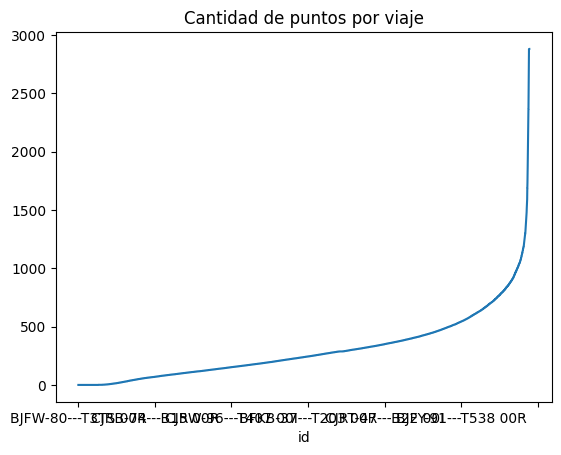

In [8]:
points_per_ride.sort_values().plot(title='Cantidad de puntos por viaje')

<Axes: title={'center': 'Distribución de cantidad de entradas por viaje'}, xlabel='count'>

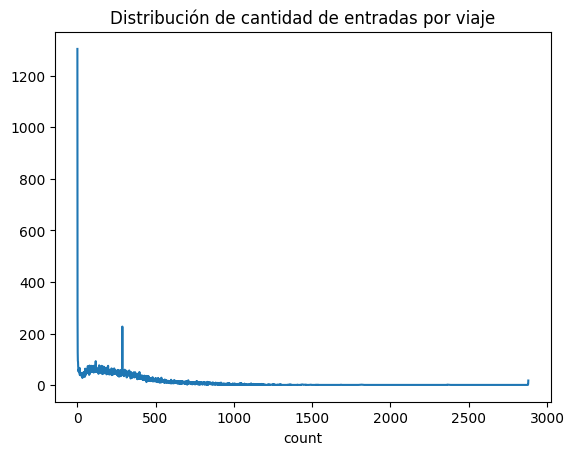

In [9]:
count_distribution = points_per_ride.value_counts()
count_distribution.sort_index().plot(title='Distribución de cantidad de entradas por viaje')

In [12]:
print("Hay {} viajes con {} entrada".format(count_distribution[count_distribution.idxmax()], count_distribution.idxmax()))
# print("Hay {} viajes con {} entrada".format(count_distribution[count_distribution.idxmin()], count_distribution.idmin()))

Hay 1303 viajes con 1 entrada


## Utilizando RDP
El algoritmo de *Ramer–Douglas–Peucker* (RDP): es un algoritmo de reducción de puntos de una línea que va descartando iterativamente los puntos que generen la menor distancia entre la curva original y la curva simplificada 

In [14]:
import rdp
from shapely import Point

# ZN-6498---T108 00R -> viaje arbitrario con 179 puntos
viaje = df[df['id'] == 'ZN-6498---T108 00R']
puntos_originales = viaje.apply(lambda row: Point(row['lat'], row['lon']), axis=1).compute()
print(puntos_originales)

/home/flac/Documents/BusY/venv/lib/python3.11/site-packages/dask_expr/_collection.py:3037: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'object'))

  warnings.warn(meta_warning(meta))


531715    POINT (-33.51791023 -70.55772418)
531716    POINT (-33.52002626 -70.55726684)
539222    POINT (-33.52214189 -70.55684177)
539223    POINT (-33.52225121 -70.55962166)
546771    POINT (-33.52226293 -70.56083855)
                        ...                
289122    POINT (-33.54313294 -70.78743772)
289123    POINT (-33.54313294 -70.78743772)
296677    POINT (-33.54300175 -70.78777964)
296678    POINT (-33.54253373 -70.78834076)
304281    POINT (-33.54132275 -70.78664662)
Length: 179, dtype: object


                           geometry
531715  POINT (-33.51791 -70.55772)
531716  POINT (-33.52003 -70.55727)
539222  POINT (-33.52214 -70.55684)
539223  POINT (-33.52225 -70.55962)
546771  POINT (-33.52226 -70.56084)
...                             ...
289122  POINT (-33.54313 -70.78744)
289123  POINT (-33.54313 -70.78744)
296677  POINT (-33.54300 -70.78778)
296678  POINT (-33.54253 -70.78834)
304281  POINT (-33.54132 -70.78665)

[179 rows x 1 columns]


(-70.78834076, -70.55684177)

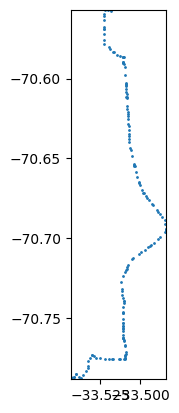

In [16]:
gdf_orig = gpd.GeoDataFrame(geometry=puntos_originales)
# print(gdf_orig)
ax = gdf_orig.plot(markersize=1)
minx, miny, maxx, maxy = gdf_orig.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

In [32]:
def list_to_geometry(L):
    for i in range(len(L)):
        L[i] = Point(L[i][0], L[i][1])
    return L


In [79]:
ALPHA = 0.0005

lista_de_listas = list(puntos_originales.apply(lambda p: [p.x, p.y]))
new_lista = rdp.rdp(lista_de_listas, ALPHA)
print("pasamos de {} a {} puntos con un alpha={}".format(len(lista_de_listas), len(new_lista), ALPHA))
gdf_new = gpd.GeoDataFrame(geometry=list_to_geometry(new_lista))
# ax = gdf_new.plot(markersize=1)
# minx, miny, maxx, maxy = gdf_orig.total_bounds
# ax.set_xlim(minx, maxx)
# ax.set_ylim(miny, maxy)

pasamos de 179 a 32 puntos con un alpha=0.0005


<Axes: >

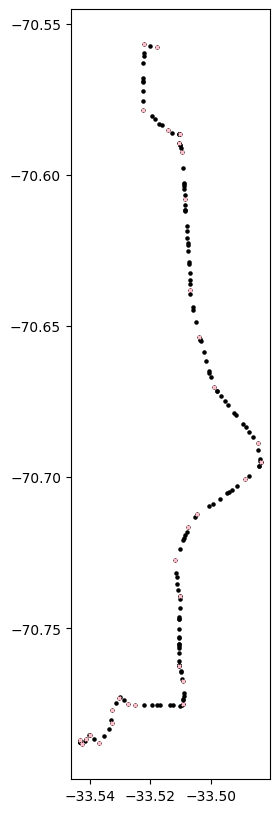

In [80]:
ax = gdf_orig.plot(markersize=5, color='black', figsize=(10,10))
gdf_new.plot(ax=ax, marker="x", markersize=5, color='pink')

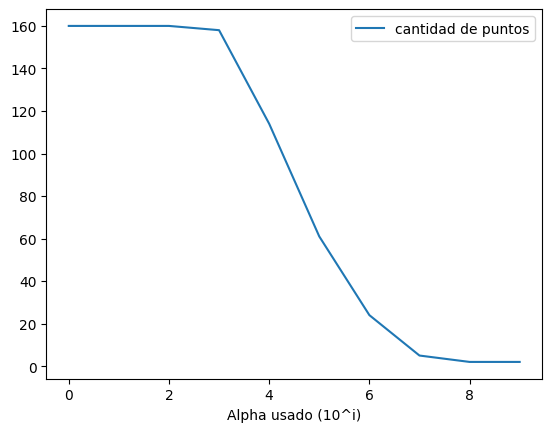

In [78]:
# como varian los puntos según alpha?
alphas = np.power([0.1 for _ in range(10)], range(10))
puntos_count = [len(rdp.rdp(lista_de_listas, alpha)) for alpha in alphas]
ax = pd.DataFrame(data={'alphas': range(10).__reversed__(), 'cantidad de puntos': puntos_count}).set_index('alphas').plot(xlabel='Alpha usado (10^i)')

## Cuál es la distribución temporal?

In [6]:
times = df['datetime'].value_counts().compute()

<Axes: xlabel='datetime'>

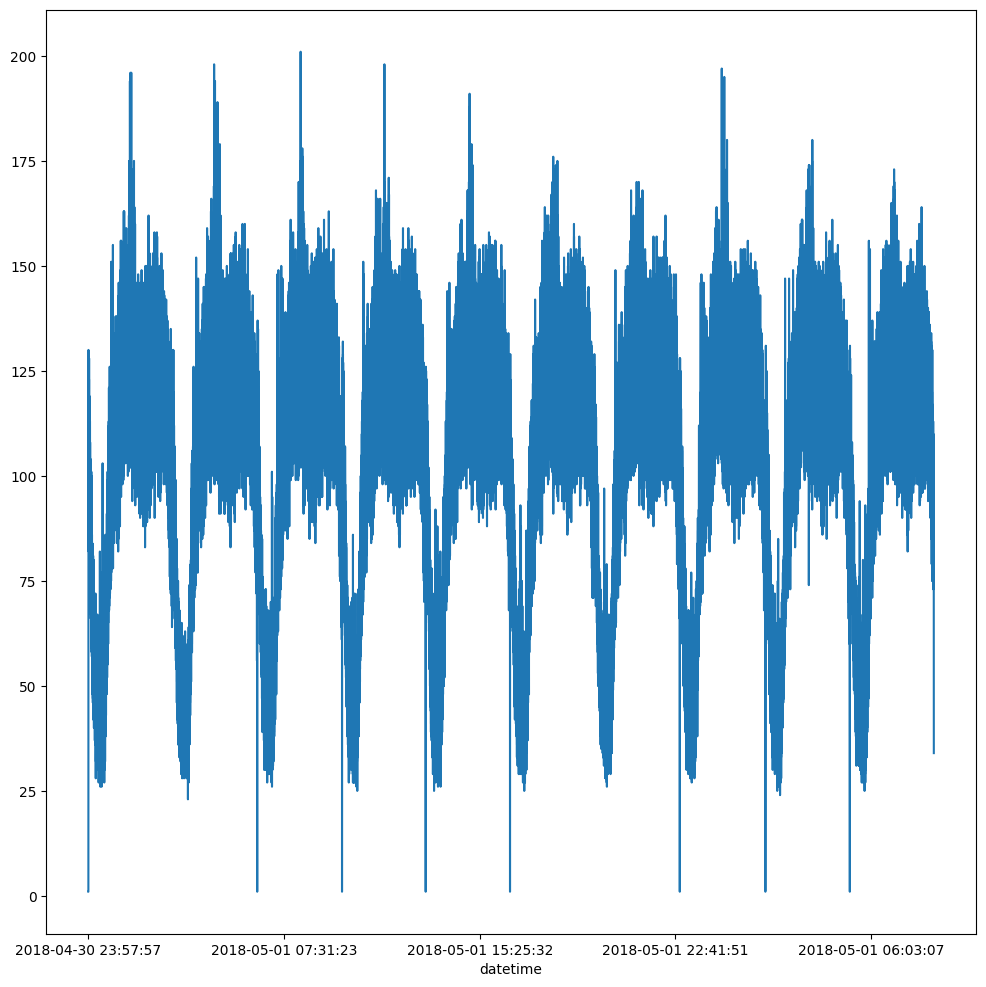

In [7]:
times.plot(figsize=(12,12))

In [8]:
# rides per service
services = df.groupby('recorrido')
points_per_service = services.apply(lambda g: len(g)) #.compute()
rides_per_service = services.apply(lambda g: len(g['patente'].value_counts())).compute()

/tmp/ipykernel_3923/3881752121.py:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  points_per_service = services.apply(lambda g: len(g)) #.compute()
/tmp/ipykernel_3923/3881752121.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  rides_per_service = services.apply(lambda g: len(g['patente'].value_counts())).compute()


<Axes: title={'center': 'Cantidad de viajes por recorrido'}, xlabel='recorrido'>

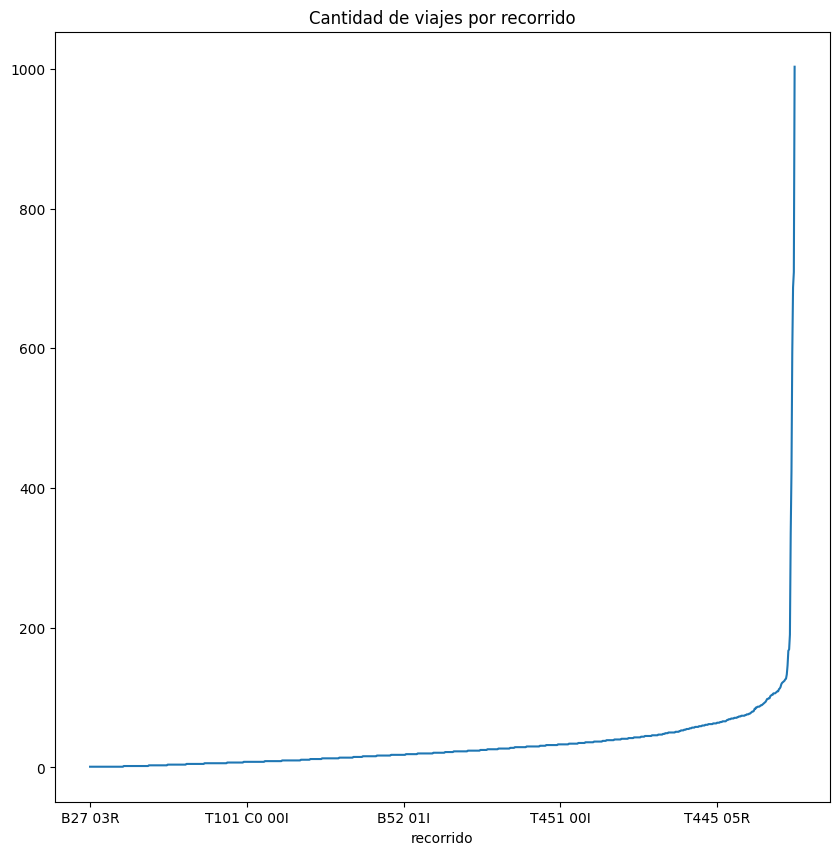

In [41]:
rides_per_service.sort_values().plot(title='Cantidad de viajes por recorrido', figsize=(10,10))

In [42]:
print("El recorrido más común es {} con {} viajes distintos".format(rides_per_service.idxmax(), rides_per_service[rides_per_service.idxmax()]))

El recorrido más común es T2TS 00I con 1003 viajes distintos
